In [4]:
import torch
from torch import nn
import torchvision

In [5]:
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

ok the next part of the code is not our objective or part of the study we are just downloading a Food101 dataset from torchvisions datasets but one that has been formated to only include only 3 classes and  like 100 of them instead of the 1000

In [6]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


ok now lets see what is in the directories we just downloaded, ineffect we will create a function that allows us to see subdirectories the number of images in each directories

In [7]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [9]:
ls

data/  sample_data/


In [10]:
ls ./data

pizza_steak_sushi/  pizza_steak_sushi.zip


In [11]:
ls ./data/pizza_steak_sushi/

test/  train/


In [12]:
ls ./data/pizza_steak_sushi/train

pizza/  steak/  sushi/


In [13]:
image_path

PosixPath('data/pizza_steak_sushi')

In [14]:
train_dir= image_path / "train"
test_dir=  image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Image path:  data/pizza_steak_sushi/test/pizza/2871261.jpg
Image class:  pizza
Image width: 512
Image height: 384 


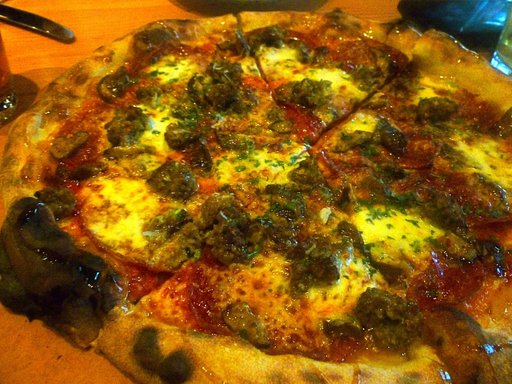

In [15]:
import random
from PIL import Image

random.seed(42)

image_path_list= list(image_path.glob("*/*/*.jpg"))
selected_image_path=random.choice(image_path_list)
selected_image_class= selected_image_path.parent.stem
img=Image.open(selected_image_path)
print("Image path: ", selected_image_path)
print("Image class: ", selected_image_class)
print(f"Image width: {img.width}")
print(f"Image height: {img.height} ")
img


Another way of displaying the picture like we did above

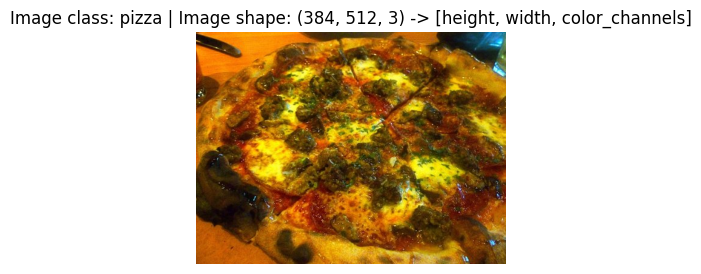

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(img_as_array)
plt.title(f"Image class: {selected_image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

Now we can not use this data(image) directly with pytorch first we need to change it to tensors and also torch.utils.data.Dataset and also create a torch.utils.data.DataLoader for it

In [17]:
from torchvision import datasets, transforms

ok now you might think we would change to numpy arrays then to tensor sine we were able to change image into a numpy representation, but that is not what is going to happen since we have many images and each inside a folder, the better and correct way to do it is using transforms

What we will do is resize our images (from 512 x 512   to 64 x 64), flip the image around ( like rotate it, this makes it harder for the model but it will later be able to identify the image in any orientation) and then change it to tensor using transforms

In [18]:
data_transform= transforms.Compose([
    transforms.Resize(size= (64,64)),
    transforms.RandomHorizontalFlip(p=0.5), #p indicates the probability it will be flipped
    transforms.ToTensor()
])

In [19]:
# lets create a function that uses the above transform to let us see an image what it looks like after transformation
def plot_transformed_images(image_paths, transform, n= 3 , seed=42):
    random.seed(seed)
    random_image_path= random.sample(image_paths, k=n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

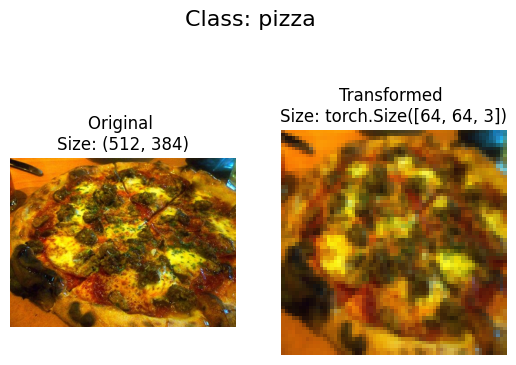

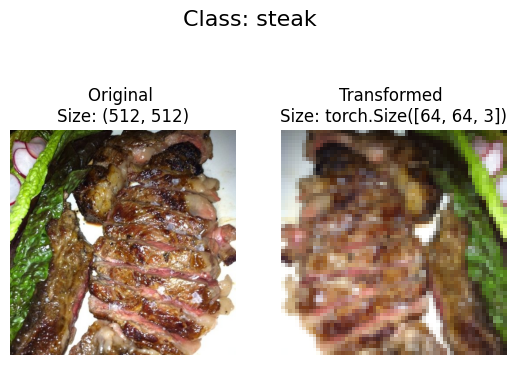

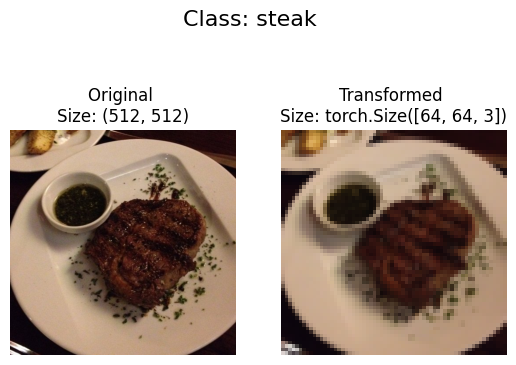

In [20]:
plot_transformed_images(image_path_list,transform=data_transform,n=3)

Now seeing how our transform worked , now we create our dataset using datasets.ImageFolder since our image folder is in a standard format where each classes of images are in their own folder and also classified under train and test

In [21]:
# first lets see what train and test path for the data
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [22]:
train_dataset= datasets.ImageFolder(
    root= train_dir,
    transform= data_transform,
    target_transform= None
)
test_dataset= datasets.ImageFolder(
    root= test_dir,
    transform= data_transform,
    target_transform= None
)

In [23]:
len(train_dataset), len(test_dataset)

(225, 75)

In [24]:
class_names= train_dataset.classes
print(class_names)
# to get classess as dictionary
class_names_dic= train_dataset.class_to_idx
print(class_names_dic)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


torch.Size([3, 64, 64])


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

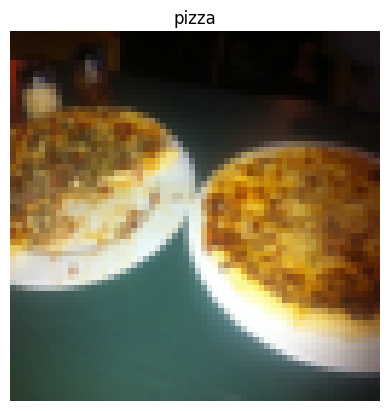

In [25]:
#lets extract an image from this dataset and look at it
img, lbl= train_dataset[0]
print(img.shape)
img= img.permute(1,2,0)
plt.imshow(img)
plt.title(class_names[lbl])
plt.axis(False)

Now its time to turn our dataset to dataloader to split them into batches

In [26]:
from torch.utils.data import DataLoader



train_batch= DataLoader(
    dataset= train_dataset,
    batch_size=1,
    num_workers=1,
    shuffle= True
)
test_batch= DataLoader(
    dataset= test_dataset,
    batch_size=1,
    num_workers=1,
    shuffle= False
)

In [27]:
imj, lbl= next(iter(train_batch))
imj, lbl

(tensor([[[[0.0549, 0.0431, 0.0431,  ..., 0.1255, 0.1451, 0.1490],
           [0.0549, 0.0510, 0.0471,  ..., 0.1490, 0.1490, 0.1490],
           [0.0588, 0.0549, 0.0471,  ..., 0.1922, 0.1765, 0.1608],
           ...,
           [0.8157, 0.8235, 0.8314,  ..., 0.3137, 0.2275, 0.2118],
           [0.8118, 0.8196, 0.8353,  ..., 0.3333, 0.2667, 0.2510],
           [0.8039, 0.8157, 0.8314,  ..., 0.4235, 0.3765, 0.3647]],
 
          [[0.0118, 0.0118, 0.0118,  ..., 0.0431, 0.0588, 0.0510],
           [0.0196, 0.0118, 0.0157,  ..., 0.0706, 0.0627, 0.0510],
           [0.0235, 0.0157, 0.0157,  ..., 0.1255, 0.1020, 0.0667],
           ...,
           [0.8314, 0.8392, 0.8510,  ..., 0.2980, 0.2000, 0.1961],
           [0.8314, 0.8431, 0.8549,  ..., 0.3294, 0.2588, 0.2431],
           [0.8353, 0.8471, 0.8549,  ..., 0.4314, 0.3725, 0.3569]],
 
          [[0.0078, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0000],
           [0.0078, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0000],
           [0.0039, 0.00

Ok great we have seen how to turn our image folders to dataset then apply dataloader to iterate them. Now the next thing would be to create a custom model normaly but the main goal of this specific practice is not about training models, rather using custom datasets. so while we turned our image folders to datasets, we will see another way that doesnt directly use Datasets ImageFolder from torchvision.datasets 

In [28]:
# here we will try to replicate the ImageFolder we used last time
import os
import torch
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

ok now we will create functions that we will use latter as methods of a class, one method we have seen was .classes and .classes_idx which returned the classes of the dataset, lets implment those

In [29]:
def find_classes(directory:str)-> Tuple[List[str], Dict[str, int]]:
    classes= sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    classes_to_idx= {cls_name:i for i, cls_name in enumerate(classes)}
    return classes, classes_to_idx

In [30]:
#lets test our function
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [31]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [32]:
#now we are going to create the custom Dataset class
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset): # we need to subclass Dataset
    def __init__(self, target_dir:str, transform:None) ->None:
        self.paths= list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform= transform
        self.classes, self.classes_to_idx = self.find_classes(target_dir)
    
    def find_classes(self,directory:str)-> Tuple[List[str], Dict[str, int]]:
        self.classes= sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not self.classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}")
        self.classes_to_idx= {cls_name:i for i, cls_name in enumerate(self.classes)}
        return self.classes, self.classes_to_idx
    
    def load_image(self, index:int):
        image_path= self.paths[index]
        return Image.open(image_path)
    
    # here we will overide the method that returns length
    def __len__(self)->int:
        return len(self.paths)
    
    # overide(necessary) getitem method which returns one sample of data (image and label)
    def __getitem__(self, index):
        img= self.load_image(index)
        class_name= self.paths[index].parent.name
        class_idx= self.classes_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


ok next step would be to test it but first lets create our transfrom that we will use

In [33]:
from torchvision import transforms

train_data_transforms= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_data_transforms= transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

Now moment of the truth, lets turn folder in to a dataset using our custom class

In [34]:
custom_train_dataset= ImageFolderCustom(
    target_dir= train_dir,
    transform=train_data_transforms
)

In [35]:
custom_train_dataset.__getitem__(0)

(tensor([[[0.8863, 0.8980, 0.9020,  ..., 0.1294, 0.1333, 0.1255],
          [0.8941, 0.9059, 0.9098,  ..., 0.2039, 0.2078, 0.2000],
          [0.8980, 0.9059, 0.9059,  ..., 0.2902, 0.2667, 0.2627],
          ...,
          [0.4471, 0.4431, 0.4353,  ..., 0.0824, 0.0549, 0.0510],
          [0.4314, 0.4275, 0.4314,  ..., 0.0431, 0.0353, 0.0431],
          [0.4314, 0.4196, 0.4196,  ..., 0.0431, 0.0784, 0.1529]],
 
         [[0.8980, 0.9137, 0.9176,  ..., 0.0863, 0.0902, 0.0824],
          [0.9059, 0.9176, 0.9255,  ..., 0.1294, 0.1294, 0.1216],
          [0.9098, 0.9176, 0.9216,  ..., 0.1922, 0.1765, 0.1725],
          ...,
          [0.3333, 0.3412, 0.3373,  ..., 0.0863, 0.0588, 0.0510],
          [0.3216, 0.3294, 0.3333,  ..., 0.0431, 0.0471, 0.0471],
          [0.3137, 0.3255, 0.3294,  ..., 0.0431, 0.0706, 0.1216]],
 
         [[0.8314, 0.8510, 0.8588,  ..., 0.0471, 0.0510, 0.0431],
          [0.8353, 0.8588, 0.8667,  ..., 0.0784, 0.0824, 0.0745],
          [0.8353, 0.8588, 0.8667,  ...,

In [36]:
custom_train_dataset.__len__()

225

In [37]:
custom_train_dataset.classes, custom_train_dataset.classes_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Great it is working, now lets create a functions that display images

In [38]:
def display_random_images(
    dataset:torch.utils.data.dataset.Dataset,
    classes:List[str] = None, 
    n:int=10,
    displayShape:bool=True,
    seed:int=None
):
    if n > 10:
        n=10
        print("For display purposes n shouldnt be greater than 10")
    if seed:
        random.seed(seed)
    else:
        random.seed(42)
    random_samples_indx= random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16,8))
    
    for i, targ_sample in enumerate(random_samples_indx):
        targ_image, targ_label= dataset[targ_sample][0], dataset[targ_sample][1]
        targ_image_adjust= targ_image.permute(1,2,0)
        plt.subplot(1,n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title= f"Class: {classes[targ_label]} "
            if displayShape:
                title= title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

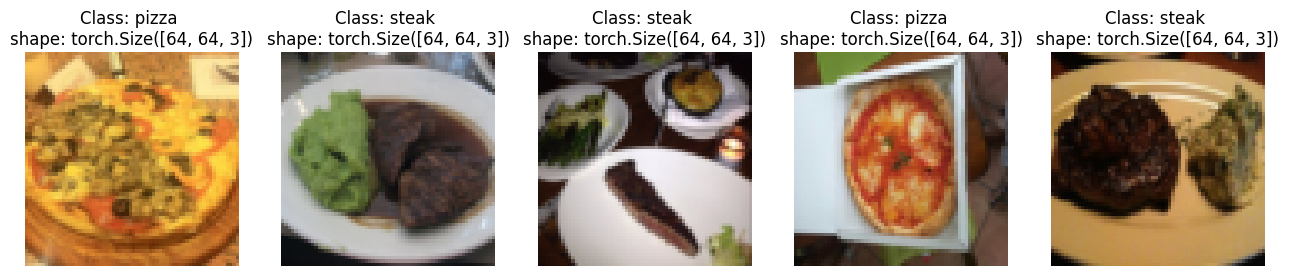

In [39]:
display_random_images(custom_train_dataset, find_classes(train_dir)[0], 5,True,42)

In [40]:
# we can do another dataloader here with our custom dataset here, lets create it

train_data_loaded= DataLoader(
    dataset= custom_train_dataset,
    batch_size=1, 
    num_workers=1,
    shuffle=True,
)

#ok i just remembered we havent created the dataset for the test part so lets do that
custom_test_dataset= ImageFolderCustom(test_dir,test_data_transforms)
# now we can apply the loader for it too
test_data_loaded= DataLoader(
    dataset= custom_test_dataset,
    batch_size=1,
    num_workers=0,
    shuffle=False
)

In [41]:
img_custom, label_custom = next(iter(test_data_loaded))
print(img_custom.shape)
print(label_custom)

torch.Size([1, 3, 64, 64])
tensor([1])


Other forms of transforms (Augementation)

The purpose of tranforms is to alter your images in some way

Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set. We will see below some examples of augments

TrivialAugment: Randomly picks one augmentation (rotate, shear, brightness, etc.)

In [42]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

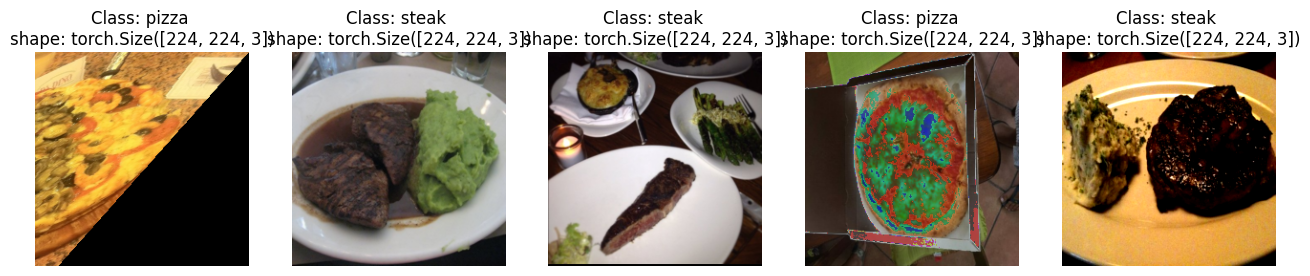

In [43]:
dtset_train=ImageFolderCustom(train_dir, train_transforms)
dtset_test= ImageFolderCustom(test_dir, test_transforms)
display_random_images(dtset_train, find_classes(train_dir)[0], 5, True, 42 )

In [44]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [45]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7b704455af60>,
 <torch.utils.data.dataloader.DataLoader at 0x7b70445889b0>)

In [46]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

        

train_data=train_data_simple.classes
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data_simple.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

lets check if it works like expected ( we dont expect true pridiction as it is not trained yet but atleast it should be capable of prediction)

In [47]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


In [48]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

Now we are going to build a train and test loop, we already have done that in previous chapters but this will be refresher and much refined version

In [49]:
from torch.utils.data import DataLoader
from torch import nn
from tqdm.auto import tqdm
from sklearn.metrics import precision_score
from timeit import default_timer as timer
def train_loop(
    model: nn.Module,
    train_data:DataLoader,
    lossFn: nn.Module,
    optimizer:torch.optim.Optimizer,
    epochs:int,
    device:torch.device
):
    accuracy_per_epoch=[]
    precision_per_epoch=[]
    loss_per_epoch=[]
    batch_count= len(train_data)
    model.to(device)
    timer_start= timer()
    for epoch in tqdm(range(epochs)):
        all_preds=[]
        all_labels=[]
        loss_total=0
        model.train()
        for i, (a_batch_images, labels) in enumerate(train_data):
            a_batch_images=a_batch_images.to(device)
            labels= labels.to(device)
            y_logits= model(a_batch_images)
            y_preds= torch.argmax(y_logits, dim=1)
            loss= lossFn(y_logits, labels)
            loss_total += loss.item()
            all_preds.append(y_preds.detach().cpu())
            all_labels.append(labels.detach().cpu())

            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
        
        all_preds= torch.cat(all_preds)
        all_labels=torch.cat(all_labels)
        accuracy_per_epoch.append((all_preds == all_labels).float().mean().item())
        loss_per_epoch.append((loss_total / batch_count))
        
        precision_per_epoch.append(precision_score(all_labels, all_preds, average="macro"))
    timer_stop= timer()
    time_taken= timer_stop - timer_start
    return {
        "accuracy_per_epoch": accuracy_per_epoch,
        "precision_per_epoch": precision_per_epoch,
        "loss_per_epoch": loss_per_epoch,
        "time_taken" : time_taken
    }

ok we will also make a much smaller functions that only does for batches not like what we did above which runs for epochs

In [50]:
def train_run(
    model:nn.Module,
    train_data:torch.utils.data.DataLoader,
    lossFn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device:torch.device    
):
    loss_total=0
    model.to(device)
    model.train()
    true_predictions=0
    total_image_count= 0
    for i, (a_batch_images, labels) in enumerate(train_data):
            a_batch_images=a_batch_images.to(device)
            labels= labels.to(device)
            y_logits= model(a_batch_images)
            y_preds= torch.argmax(y_logits, dim=1)
            loss= lossFn(y_logits, labels)
            loss_total += loss.item()
            true_predictions += (labels == y_preds).sum().item()
            total_image_count += len(labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
    loss= loss_total / len(train_data)
    accuracy = true_predictions /  total_image_count
    return {
        'loss': loss,
        'accuracy': accuracy
    }

In [51]:
def test_run(
    model: nn.Module,
    test_data: torch.utils.data.DataLoader,
    lossFn: nn.Module,
    device: torch.device
):
    loss_total = 0
    true_predictions = 0
    total_image_count = 0

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for i, (a_batch_images, labels) in enumerate(test_data):
            a_batch_images = a_batch_images.to(device)
            labels = labels.to(device)

            y_logits = model(a_batch_images)
            y_preds = torch.argmax(y_logits, dim=1)

            loss = lossFn(y_logits, labels)
            loss_total += loss.item()

            true_predictions += (labels == y_preds).sum().item()
            total_image_count += len(labels)

    loss = loss_total / len(test_data)
    accuracy = true_predictions / total_image_count

    return {
        "loss": loss,
        "accuracy": accuracy
    }

In [52]:
from tqdm.auto import tqdm

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    device: torch.device,
    epochs: int = 5
):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):

        train_metrics = train_run(
            model=model,
            train_data=train_dataloader,
            lossFn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        test_metrics = test_run(
            model=model,
            test_data=test_dataloader,
            lossFn=loss_fn,
            device=device
        )

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_metrics['loss']:.4f} | "
            f"train_acc: {train_metrics['accuracy']:.4f} | "
            f"test_loss: {test_metrics['loss']:.4f} | "
            f"test_acc: {test_metrics['accuracy']:.4f}"
        )

        results["train_loss"].append(train_metrics["loss"])
        results["train_acc"].append(train_metrics["accuracy"])
        results["test_loss"].append(test_metrics["loss"])
        results["test_acc"].append(test_metrics["accuracy"])

    return results

In [53]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 5
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(train_data_simple.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device= device,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2933 | test_loss: 1.1362 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.3467 | test_loss: 1.1622 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.3333 | test_loss: 1.1695 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.0988 | train_acc: 0.3333 | test_loss: 1.1343 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3333 | test_loss: 1.1434 | test_acc: 0.2533
Total training time: 4.415 seconds


From the print outs of our model_0 training, it didn't look like it did too well. But we can further evaluate it by plotting the model's loss curves.

In [54]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [55]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

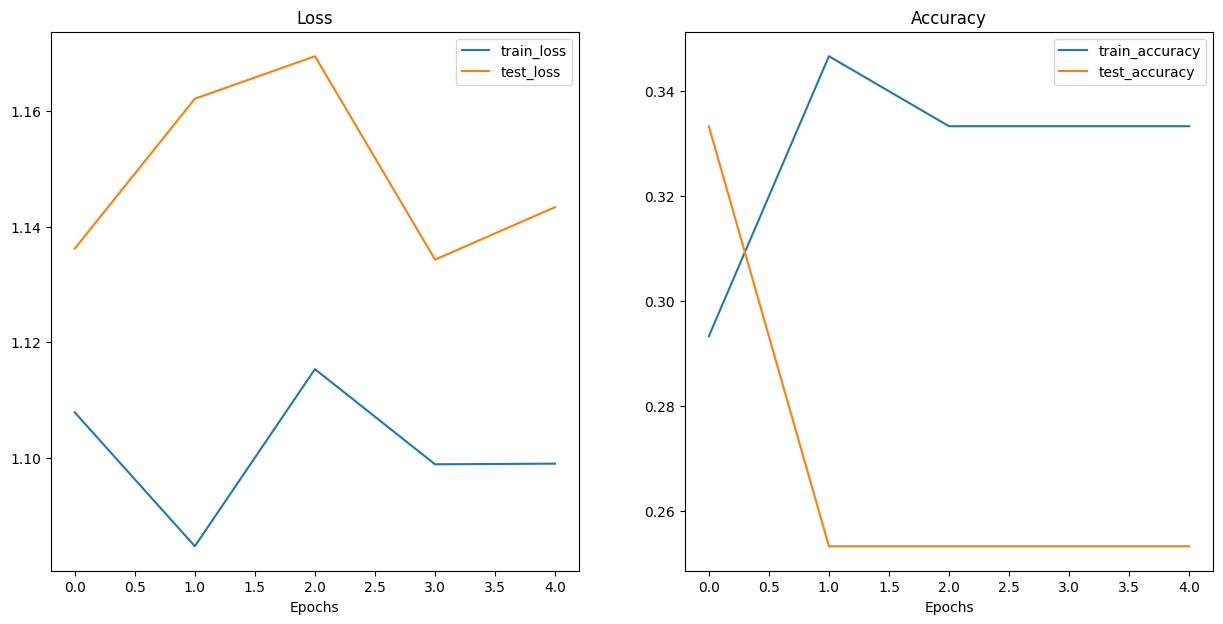

In [56]:
plot_loss_curves(model_0_results)

While the above data would not perfectly show us what overfitting looks like, it shows the result of overfitting as the train_loss is below or very lower while the test_loss is on the upper side and there is huge gap between them

Overfitting

Problem: Model learns the training data too well → poor performance on new data.

Fixes:

More data → model sees more variety, learns general patterns.

Simpler model → fewer layers or units to reduce memorization.

Data augmentation → artificially increase data diversity.

Transfer learning → use pretrained models instead of starting from scratch.

Dropout layers → randomly remove connections to force robustness.

Learning rate decay → gradually reduce learning steps as model converges.

Early stopping → stop training when validation loss stops improving.

Underfitting

Problem: Model cannot learn patterns even on training data → high loss everywhere.

Fixes:

Larger model → more layers or units to capture complexity.

Tweak learning rate → lower it if updates are too aggressive.

Transfer learning → start from a model that already learned patterns.

Train longer → give the model more epochs to learn.

Less regularization → don’t constrain the model too much.

Balance

Overfitting and underfitting are opposite ends of a spectrum.

Too much focus on one can make the other worse.

Transfer learning is a strong way to avoid both: use a pretrained model and adapt it.

# Ok i think this file has gone too long so we will have part 2 for this